Use GPyTorch
Use Spectral Mixture kernel

In [1]:
import math
import torch
import gpytorch
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

Read the first time series

In [2]:
USE_CUDA = False
#if torch.cuda.device_count() > 0:
#    torch.cuda.set_device(0)
#    print("USE GPU")

In [3]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [4]:
df = pd.read_csv("../data/sim_eb.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [5]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
Plot the data

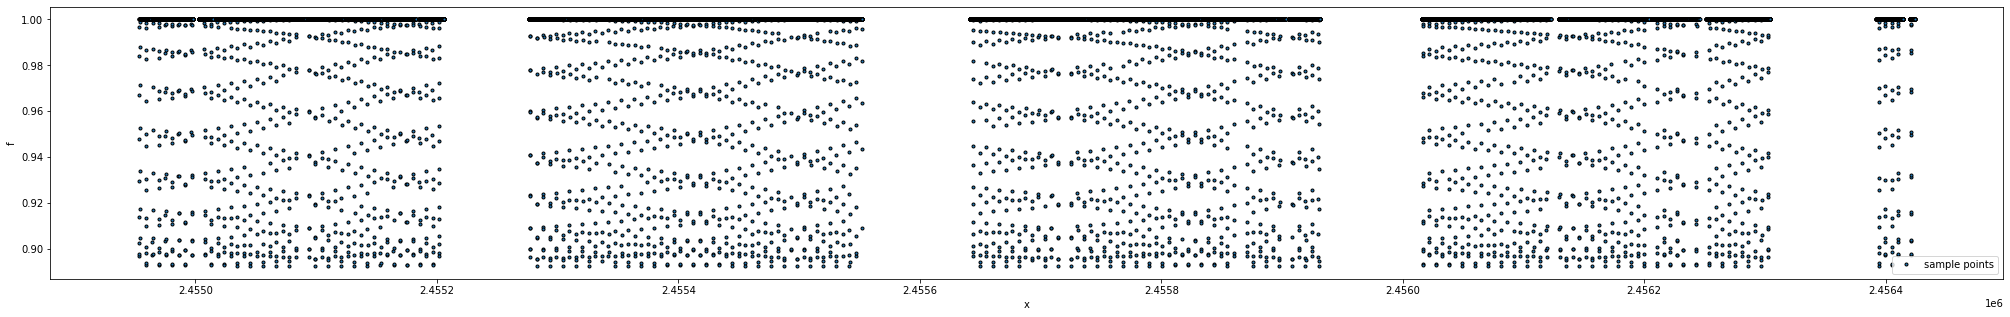

In [6]:
# Setup our figure environment
plt.figure(figsize=(35, 5))

# Plot observations
plt.plot(X, Y, ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["sample points"]);

Zoomed in on the first N observations

In [7]:
frequency, power = LombScargle(X, Y).autopower(minimum_frequency=0.0, maximum_frequency=5)
frequency, power

(array([0.00000000e+00, 1.36011628e-04, 2.72023257e-04, ...,
        4.99978746e+00, 4.99992347e+00, 5.00005948e+00]),
 array([           inf, 1.02450126e-05, 1.03251269e-05, ...,
        1.26181187e-06, 1.34122449e-06, 9.75167114e-07]))

(Text(0.5, 0, 'frequency'), Text(0, 0.5, 'power'))

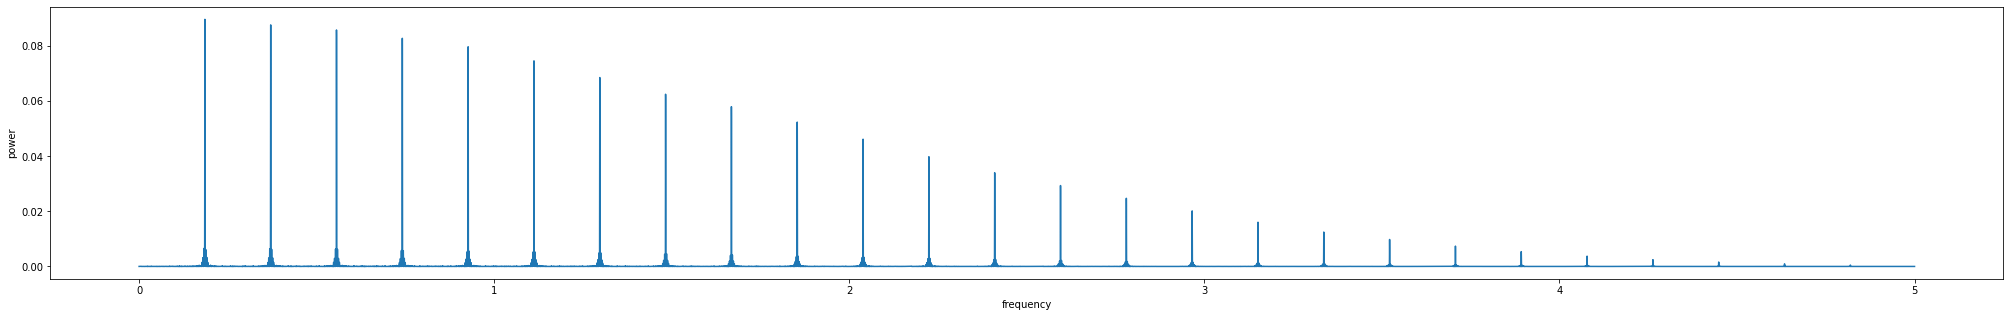

In [8]:
plt.figure(figsize=(35, 5))
plt.plot(frequency, power)
plt.xlabel("frequency"), plt.ylabel("power")

In [17]:
N_part=1000

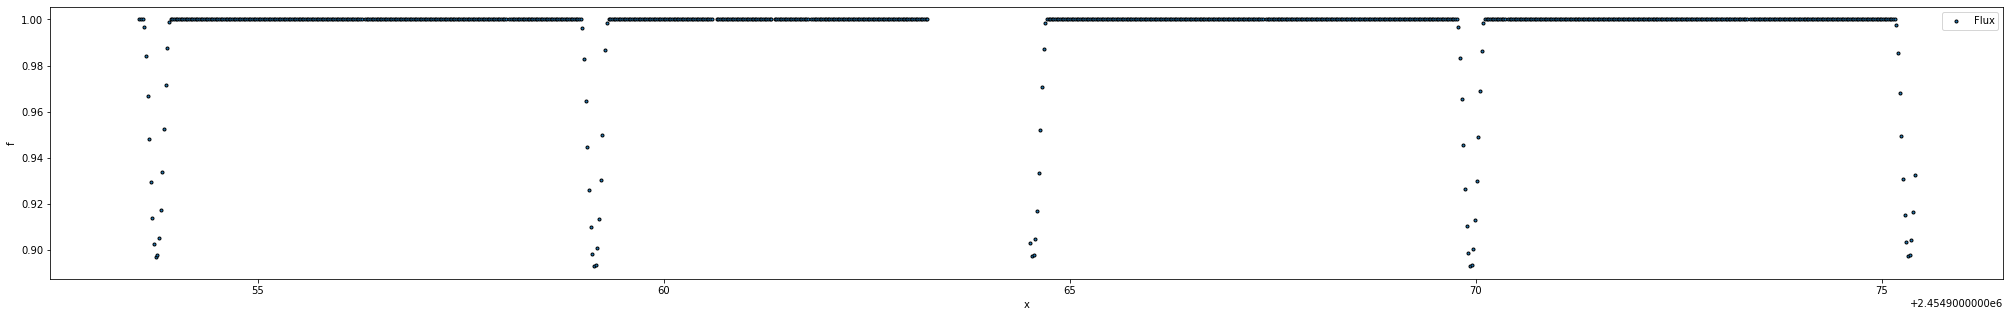

In [18]:
# Setup our figure environment
plt.figure(figsize=(35, 5))

# Plot observations
plt.plot(X[:N_part], Y[:N_part], ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["Flux"]);

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [19]:
def plot_kernel_samples(model, x, nr_of_samples=5):
    plt.figure(figsize=(35, 8))
    for i in range(nr_of_samples):
        Y_sample = model(x).sample()
        N = Y_sample.shape[0]
        plt.plot(range(N), Y_sample)

def plot_series(data_x, data_y, smooth_x=None, smooth_y=None, var=None):
    # Plot
    plt.figure(figsize=(35, 8))
    plt.plot(data_x, data_y, ".", mew=1, linewidth=1, mec="black", label='truth')
    #plt.plot(tsmooth, ysignal, 'r', label='truth')
    #plt.errorbar(t, y, yerr, fmt='.', color='k', label='meas.')
    if not smooth_x is None:
        if not var is None:
            plt.fill_between(smooth_x, smooth_y-np.sqrt(var), smooth_y+np.sqrt(var), color='g', alpha=0.5)
        plt.plot(smooth_x, smooth_y, 'r', label='predict.')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend()
    
def plot_1d_kernel(kernel):
    # Setup our figure environment
    plt.figure(figsize=(35, 5))

    # Predict evenly spaced points on our time-axis
    x = np.linspace(-6, 6, 1000)
    y = kernel.eval(x)
    
    # Plot observations
    plt.plot(x, y, ".", mew=1, linewidth=1, mec="black")

    # Annotate plot
    plt.xlabel("x"), plt.ylabel("f")
    plt.legend(labels=["sample points"])

def eval_2d(x):
    return np.array([x-i for i in x.tolist()])
    
def plot_2d_kernel(kernel):
    # Our sample space
    x = np.linspace(-5., 5., 250)
    grid = eval_2d(x)
    C = kernel.eval(grid)

    # Visualise covariance matrix on right hand side
    plt.pcolor(x.T, x, C)
    # Annotate plot
    plt.gca().invert_yaxis(), plt.gca().axis("image")
    plt.colorbar()

In [20]:
X_part=torch.tensor(X[:N_part])
Y_part=torch.tensor(Y[:N_part])

In [21]:
# Predict evenly spaced points on our time-axis
X_part_smooth = torch.tensor(np.linspace(X_part.min(), X_part.max(), N_part))

In [22]:
# normalize labels
mean, std = Y_part.mean(),Y_part.std()
Y_part = (Y_part - mean) / std

In [23]:
X_part,Y_part

(tensor([2454953.5392, 2454953.5597, 2454953.5801, 2454953.6005, 2454953.6210,
         2454953.6414, 2454953.6618, 2454953.6823, 2454953.7027, 2454953.7231,
         2454953.7436, 2454953.7640, 2454953.7844, 2454953.8049, 2454953.8253,
         2454953.8457, 2454953.8662, 2454953.8866, 2454953.9070, 2454953.9275,
         2454953.9479, 2454953.9683, 2454953.9888, 2454954.0092, 2454954.0296,
         2454954.0501, 2454954.0705, 2454954.0910, 2454954.1114, 2454954.1318,
         2454954.1523, 2454954.1727, 2454954.1931, 2454954.2136, 2454954.2340,
         2454954.2544, 2454954.2749, 2454954.2953, 2454954.3157, 2454954.3362,
         2454954.3566, 2454954.3770, 2454954.3975, 2454954.4179, 2454954.4383,
         2454954.4588, 2454954.4792, 2454954.4996, 2454954.5201, 2454954.5405,
         2454954.5609, 2454954.5814, 2454954.6018, 2454954.6222, 2454954.6427,
         2454954.6631, 2454954.6835, 2454954.7040, 2454954.7244, 2454954.7448,
         2454954.7653, 2454954.7857, 2454954.8062, 2

(Text(0.5, 0, 'frequency'), Text(0, 0.5, 'power'))

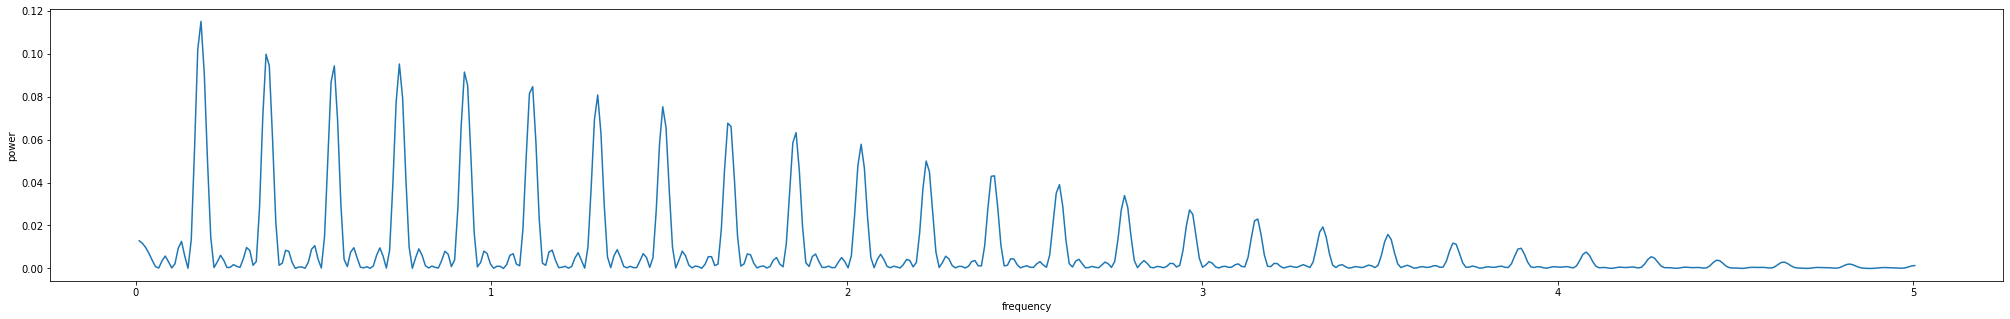

In [24]:
frequency, power = LombScargle(X_part, Y_part).autopower(minimum_frequency=0.0, maximum_frequency=5)
frequency, power
plt.figure(figsize=(35, 5))
plt.plot(frequency, power)
plt.xlabel("frequency"), plt.ylabel("power")

In [17]:
Y_part.cpu().numpy().mean()

6.431122301364667e-15

In [18]:
NUM_MIXTURES=25

In [19]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
#        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
#        self.covar_module = gpytorch.kernels.RBFKernel()
#        self.covar_module.lengthscale = 0.1
#        self.covar_module = gpytorch.kernels.ScaleKernel(self.covar_module)
        self.covar_module = gpytorch.kernels.PeriodicKernel()
        self.covar_module.period_length = 1.7
        self.covar_module = gpytorch.kernels.ScaleKernel(self.covar_module)
       
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=NUM_MIXTURES)
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
#model = ExactGPModel(X_part, Y_part, likelihood)
model = SpectralMixtureGPModel(X_part, Y_part, likelihood)

# As we are using float64 data, we need to convert our model to double
_ = model.double()
_ = likelihood.double()

Move data and models to the GPU

In [20]:
if USE_CUDA:
    X_part = X_part.cuda()
    X_part_smooth = X_part_smooth.cuda()
    Y_part = Y_part.cuda()
    model = model.cuda()
    likelihood = likelihood.cuda()

In [21]:
training_iter = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.15)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_part)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_part)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   period: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        0,
#        model.covar_module.period_length.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.516   period: 0.000   noise: 0.693
Iter 2/50 - Loss: 1.443   period: 0.000   noise: 0.771
Iter 3/50 - Loss: 1.439   period: 0.000   noise: 0.842
Iter 4/50 - Loss: 1.416   period: 0.000   noise: 0.905
Iter 5/50 - Loss: 1.406   period: 0.000   noise: 0.947
Iter 6/50 - Loss: 1.363   period: 0.000   noise: 0.966
Iter 7/50 - Loss: 1.364   period: 0.000   noise: 0.957
Iter 8/50 - Loss: 1.327   period: 0.000   noise: 0.928
Iter 9/50 - Loss: 1.284   period: 0.000   noise: 0.887
Iter 10/50 - Loss: 1.266   period: 0.000   noise: 0.835
Iter 11/50 - Loss: 1.212   period: 0.000   noise: 0.777
Iter 12/50 - Loss: 1.145   period: 0.000   noise: 0.715
Iter 13/50 - Loss: 1.070   period: 0.000   noise: 0.652
Iter 14/50 - Loss: 0.998   period: 0.000   noise: 0.589
Iter 15/50 - Loss: 0.935   period: 0.000   noise: 0.528
Iter 16/50 - Loss: 0.873   period: 0.000   noise: 0.470
Iter 17/50 - Loss: 0.819   period: 0.000   noise: 0.415
Iter 18/50 - Loss: 0.767   period: 0.000   noise: 0.364
I

In [22]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along train_x
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_part_smooth))

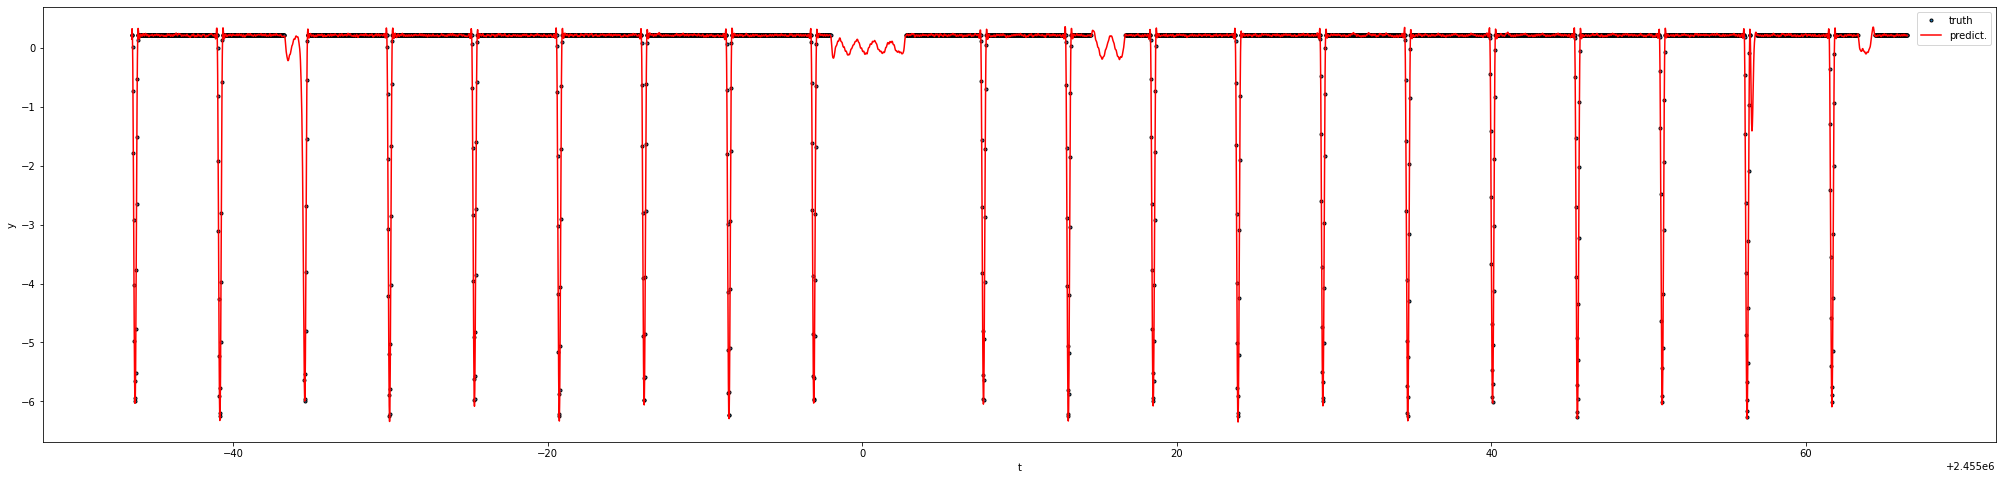

In [23]:
with torch.no_grad():
    plot_series(X_part.cpu().numpy(), Y_part.cpu().numpy(), X_part_smooth.cpu().numpy(), observed_pred.mean.cpu().numpy())

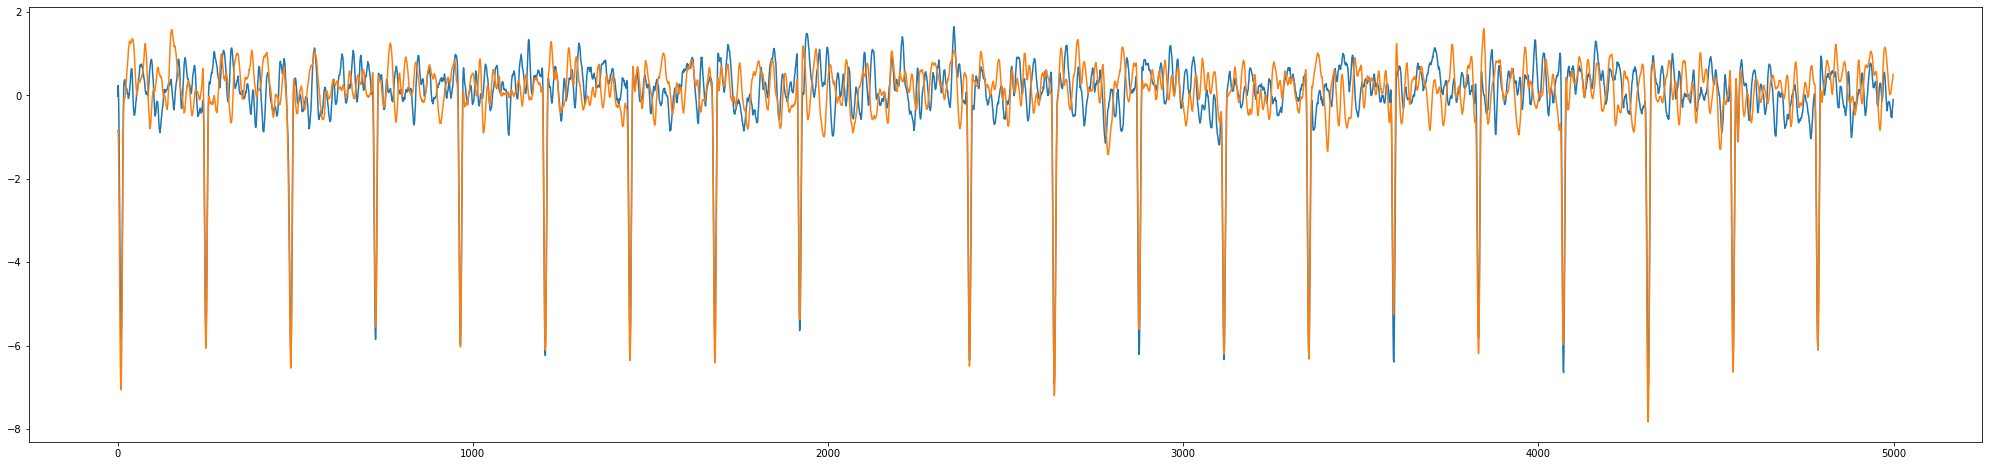

In [26]:
# Plot some samples of the kernel
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    plot_kernel_samples(model, X_part_smooth, nr_of_samples=2)

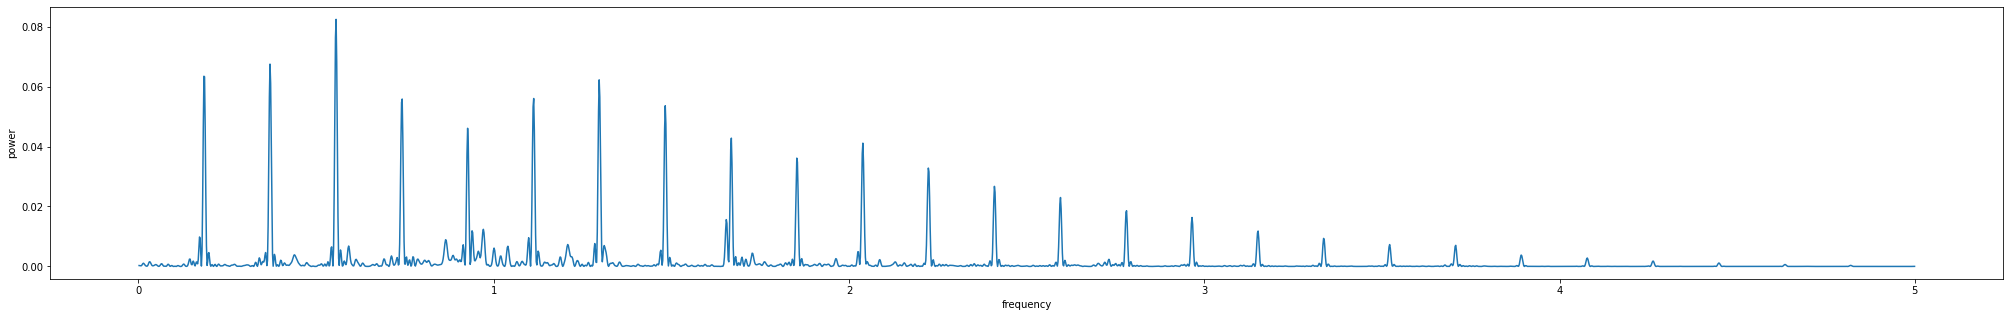

In [27]:
# Plot the periodogram of one sample
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    Y_sample = model(X_part_smooth).sample()
    frequency, power = LombScargle(X_part_smooth, Y_sample).autopower(minimum_frequency=0.0, maximum_frequency=5)
    plt.figure(figsize=(35, 5))
    plt.plot(frequency, power)
    plt.xlabel("frequency"), plt.ylabel("power")

In [28]:
with torch.no_grad():
    print("Mixture scales: ", model.covar_module.mixture_scales.cpu().numpy().tolist())
    print("Micture means:", model.covar_module.mixture_means.cpu().numpy())

Mixture scales:  [[[0.00026540105269355017]], [[0.00013656501906499603]], [[0.00010479023174920954]], [[0.00017506543761564597]], [[1.216749908039693]], [[0.00013474668823343556]], [[0.0001435214283710063]], [[0.03321958693347608]], [[0.0001897215639956838]], [[0.00019830899521257713]], [[0.0001918857226440047]], [[0.00012796926726610282]], [[0.00020254902925978294]], [[0.00016117983800852941]], [[0.00011073209546197996]], [[0.00027339460688356157]], [[0.00024900317760591134]], [[0.0003680147568083241]], [[0.0001431885754721217]], [[0.006957394392274688]], [[0.0002596303811005158]], [[1.3565050632897315]], [[0.00024013545346333805]], [[0.0006151177364865812]], [[0.00014034975624548267]]]
Micture means: [[[14.29716535]]

 [[ 7.83675514]]

 [[ 7.226955  ]]

 [[13.16789174]]

 [[ 1.04471284]]

 [[24.47838091]]

 [[ 9.15407393]]

 [[ 0.91902223]]

 [[17.74948782]]

 [[14.05711746]]

 [[24.88346818]]

 [[18.73176671]]

 [[20.22832634]]

 [[ 9.52760944]]

 [[18.55657464]]

 [[10.52675766]]



In [29]:
with torch.no_grad():
    residuals = Y_part.cpu()-observed_pred.mean.cpu().numpy()

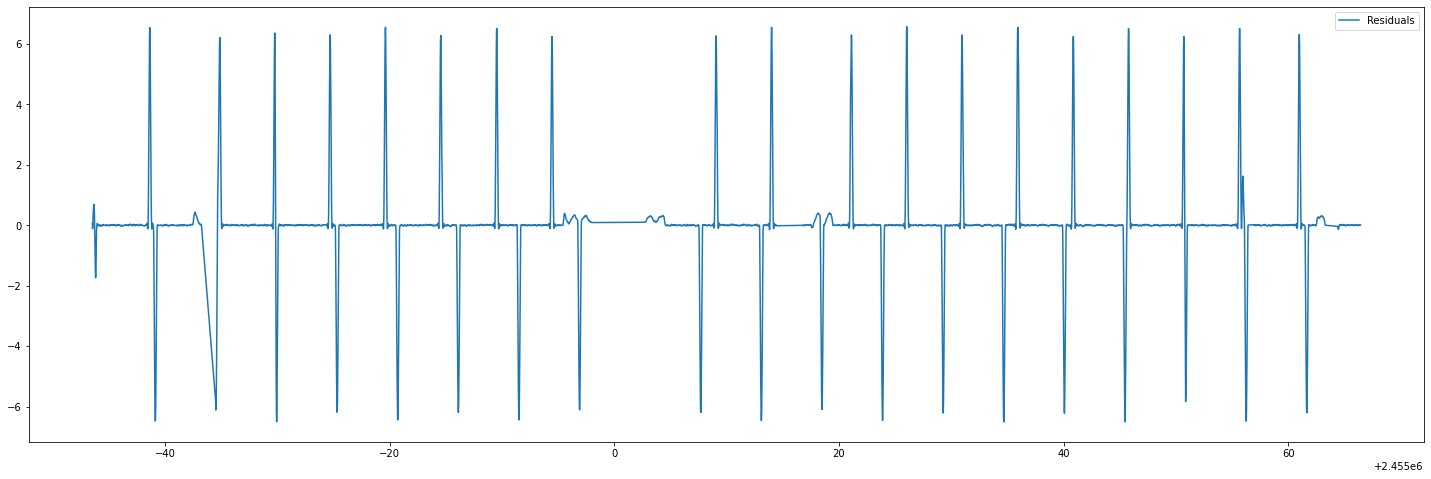

In [30]:
# Plot GP residuals
plt.figure(figsize=(25, 8))
plt.plot(X_part.cpu(), residuals, "-")
plt.legend(labels=["Residuals"])

### RMSE

In [33]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_part))
    
np.sqrt(np.nanmean((observed_pred.mean.cpu().numpy()-Y_part.cpu().numpy())**2))

0.029382353764494433